# Fish Market Weight Analysis - Regression Modelling

![Alt Text](https://images.unsplash.com/photo-1611214774777-3d997a9d0e35?ixlib=rb-4.0.3&ixid=M3wxMjA3fDB8MHxzZWFyY2h8NHx8ZmlzaCUyMG1hcmtldHxlbnwwfHwwfHx8MA%3D%3D&w=1000&q=80)


# Import stuff

In [143]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor 
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler

import optuna

# Data Loading and Info

In [144]:
df = pd.read_csv('https://raw.githubusercontent.com/Ankit152/Fish-Market/main/Fish.csv')
df.head()

,Species,Weight,Length1,Length2,Length3,Height,Width
0,Bream,242.0,23.2,25.4,30.0,11.5200,4.0200
1,Bream,290.0,24.0,26.3,31.2,12.4800,4.3056
2,Bream,340.0,23.9,26.5,31.1,12.3778,4.6961
3,Bream,363.0,26.3,29.0,33.5,12.7300,4.4555
4,Bream,430.0,26.5,29.0,34.0,12.4440,5.1340


In [145]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159 entries, 0 to 158
Data columns (total 7 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Species  159 non-null    object 
 1   Weight   159 non-null    float64
 2   Length1  159 non-null    float64
 3   Length2  159 non-null    float64
 4   Length3  159 non-null    float64
 5   Height   159 non-null    float64
 6   Width    159 non-null    float64
dtypes: float64(6), object(1)
memory usage: 8.8+ KB


## Info

* 7 cols, 1 cat, 6 numerical
* Weight as label, 6 features
* no null values, check duplicates?
* unique species? balanced dataset?
* check distribution of numericals

In [146]:
df.describe()

,Weight,Length1,Length2,Length3,Height,Width
count,159.000000,159.000000,159.000000,159.000000,159.000000,159.000000
mean,398.326415,26.247170,28.415723,31.227044,8.970994,4.417486
std,357.978317,9.996441,10.716328,11.610246,4.286208,1.685804
min,0.000000,7.500000,8.400000,8.800000,1.728400,1.047600
25%,120.000000,19.050000,21.000000,23.150000,5.944800,3.385650
50%,273.000000,25.200000,27.300000,29.400000,7.786000,4.248500
75%,650.000000,32.700000,35.500000,39.650000,12.365900,5.584500
max,1650.000000,59.000000,63.400000,68.000000,18.957000,8.142000


## Describe

* Weight min of 0? need to clean
* length mean +- std looks decent, not like the weight data mistake
* same for height and width, guess we have to check and atleast remove the 0 weight

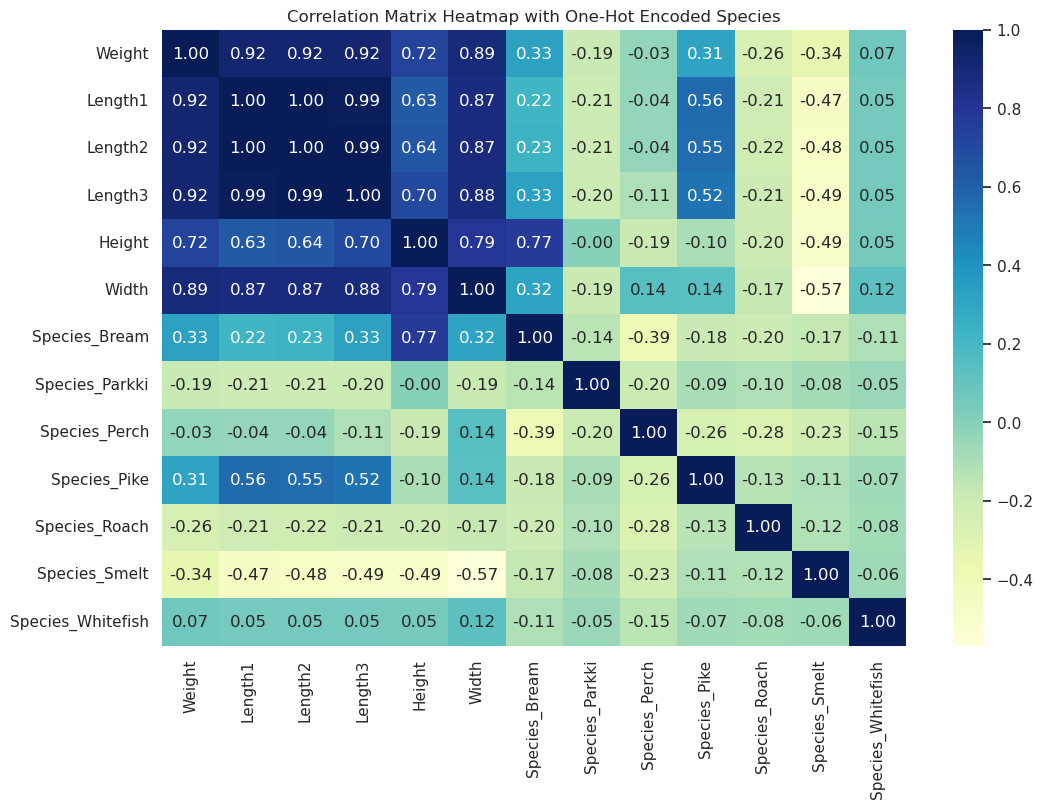

In [147]:
# OHE to show cat feature
df_encoded = pd.get_dummies(df, columns=['Species'], prefix=['Species'])

correlation_matrix = df_encoded.corr()

plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="YlGnBu", fmt=".2f")
plt.title("Correlation Matrix Heatmap with One-Hot Encoded Species")
plt.show()

## corrmatrix

* high corr between different lengths, all fishs seems to have the same shape?
* all numerical features highly correlated with weight, height with the lowest, but still at 0.72
* Bream and Pike highest correlations, heaviest fish, Roach and Smelt large negative, lightest fish

In [148]:
df.groupby('Species').agg({'Weight':'mean'}).sort_values(by = 'Weight')

,Weight
Species,
Smelt,11.178571
Roach,152.050000
Parkki,154.818182
Perch,382.239286
Whitefish,531.000000
Bream,617.828571
Pike,718.705882


Yep, turns out Smelt is by far the lightest and pike the heaviest fish

/opt/conda/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


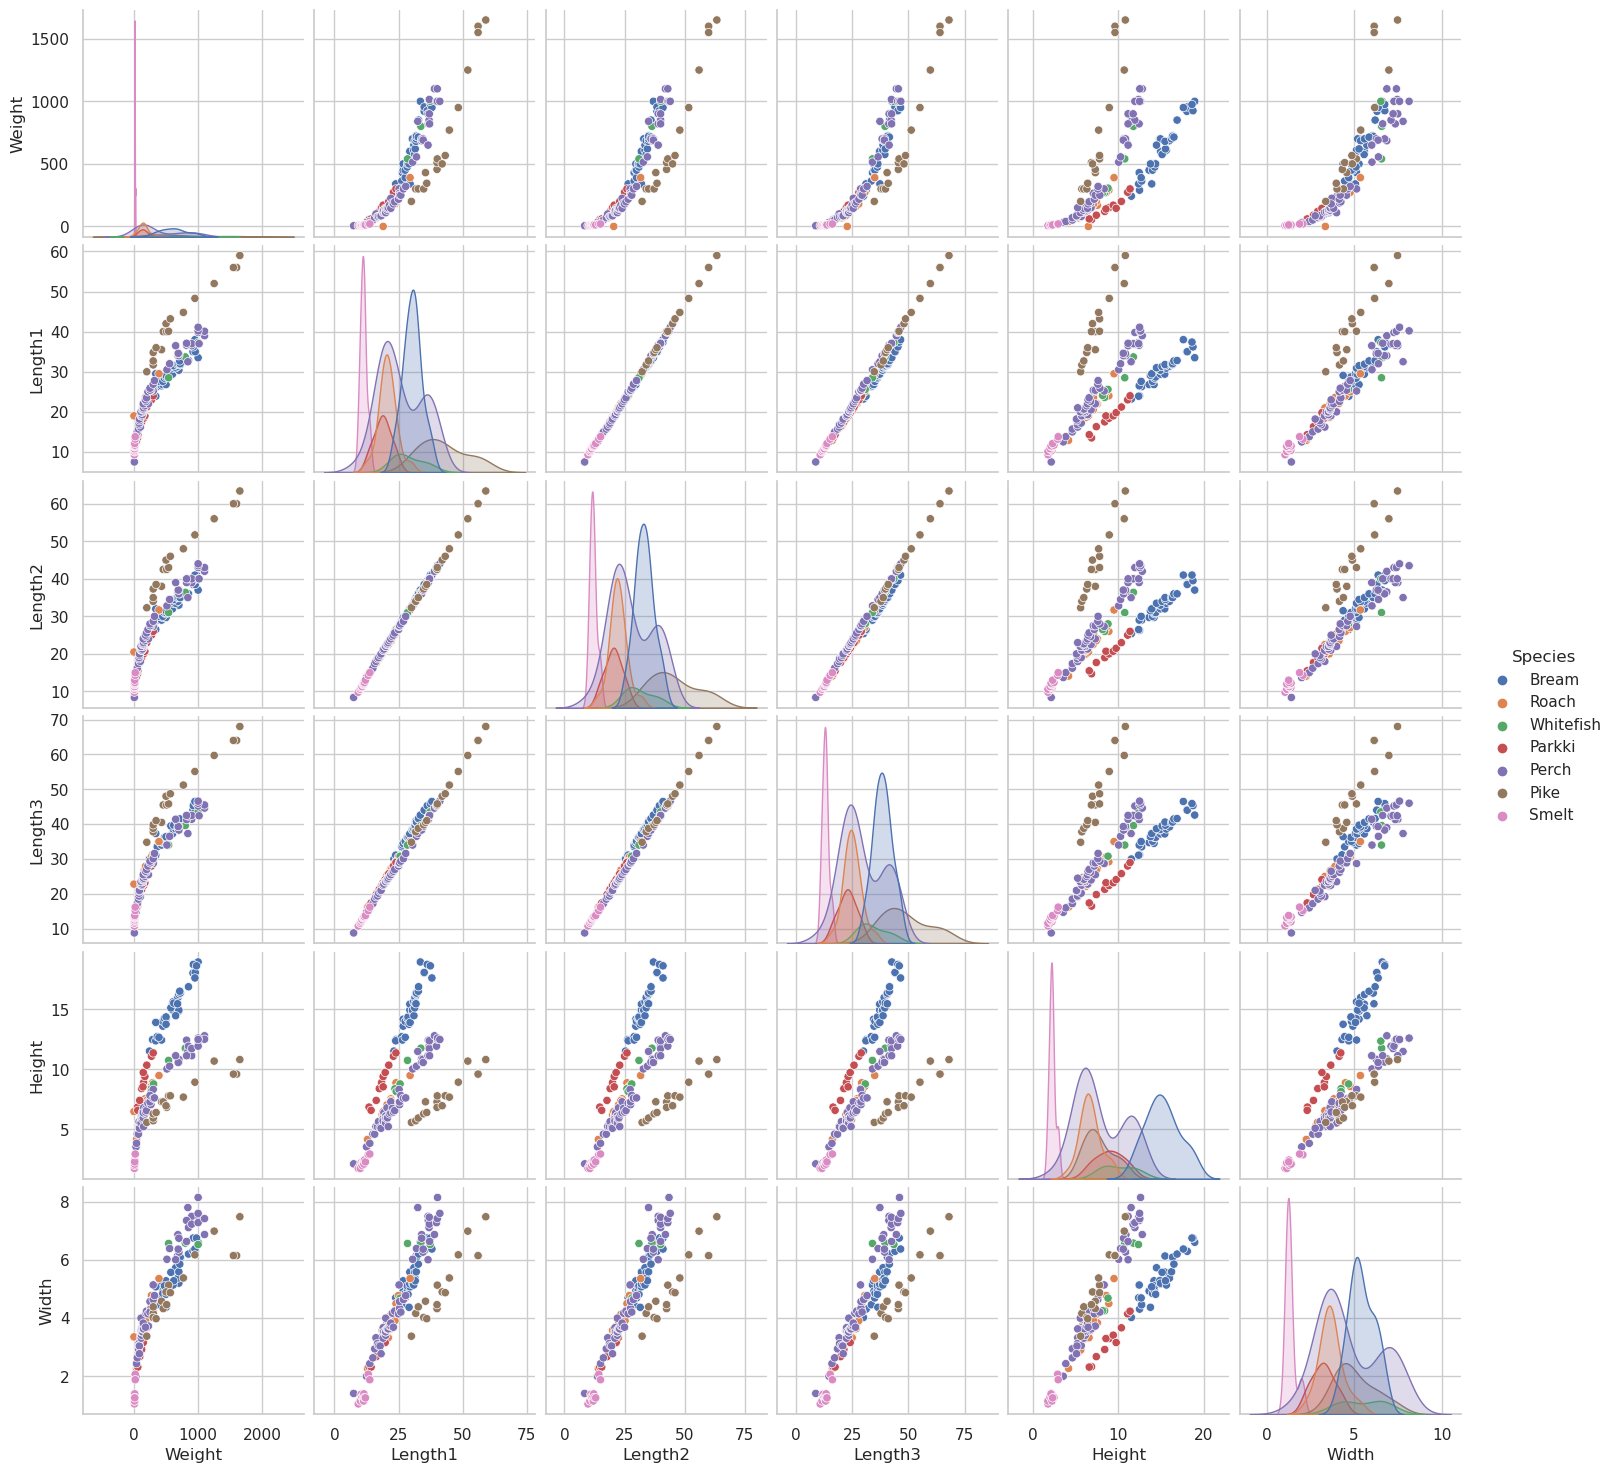

In [149]:
sns.pairplot(data = df , hue = 'Species');

## Pairplot

* multicollinearity, backs up results from corr_matrix
* many strong linear relations, but some non-linear relations, maybe LinearRegression wont be the best model choice, we'll see

# Cleaning + Engi

In [150]:
# read data from github
df = pd.read_csv('https://raw.githubusercontent.com/Ankit152/Fish-Market/main/Fish.csv')

# find the fish with weight 0
print(df[df['Weight'] == 0])

# remove from the dataset
df = df[df['Weight'] != 0]

# scale numerical features
numerical_features = df.drop(['Species', 'Weight'], axis=1)

scaler = StandardScaler()

df[numerical_features.columns] = scaler.fit_transform(numerical_features)

# OHE
df = pd.get_dummies(df, columns=['Species'], prefix=['Species'])

   Species  Weight  Length1  Length2  Length3  Height   Width
40   Roach     0.0     19.0     20.5     22.8  6.4752  3.3516


In [151]:
df.head()

,Weight,Length1,Length2,Length3,Height,Width,Species_Bream,Species_Parkki,Species_Perch,Species_Pike,Species_Roach,Species_Smelt,Species_Whitefish
0,242.0,-0.309933,-0.286587,-0.110466,0.591654,-0.240092,1,0,0,0,0,0,0
1,290.0,-0.229770,-0.202457,-0.006935,0.815870,-0.070461,1,0,0,0,0,0,0
2,340.0,-0.239791,-0.183761,-0.015562,0.792000,0.161475,1,0,0,0,0,0,0
3,363.0,0.000698,0.049934,0.191499,0.874260,0.018572,1,0,0,0,0,0,0
4,430.0,0.020738,0.049934,0.234637,0.807462,0.421564,1,0,0,0,0,0,0


# Model

## Linear Regression

In [152]:
# features and label
X = df.drop('Weight', axis = 1)
y = df['Weight']

# split
X_train, X_test, y_train, y_test = (train_test_split(X, 
                                                     y, 
                                                     test_size=0.2, 
                                                     shuffle=True, 
                                                     random_state=42))

# fit
lr = LinearRegression()
lr.fit(X_train, y_train)

# coefficients
print("Coefficients:", lr.coef_)
print("\nIntercept:", lr.intercept_)

# predict
y_pred = lr.predict(X_test)
print("\nPredictions:", y_pred)

# metrics
print("\nMean Squared Error (MSE):", mean_squared_error(y_test, y_pred))
print("\nR-squared (R^2):", r2_score(y_test, y_pred))
print("\nMean Absolute Error (MAE):", mean_absolute_error(y_test, y_pred))

Coefficients: [-631.00904886  705.50848567  378.21603522  -57.748672     24.86295114
  -23.75789954  109.67672503   14.62998401 -386.38116849  -14.93776981
  289.50304796   11.26708083]

Intercept: 409.5038512508156

Predictions: [ 2.99256396e+02  1.47497463e+02  5.75658901e+02  1.15580474e+02
  1.89824887e+02  7.59948340e+02  2.38819720e+02  2.71211358e+02
  2.24931743e+02  1.15580555e+03  6.07478516e+02  4.24811922e+02
  5.45590210e+02  3.59307063e+02  6.82356607e+02  8.21003683e+02
  9.32545191e+02  6.43425463e+02  2.16128417e+02  1.93865677e+02
 -3.64260773e-01  5.86134621e+02  5.10224795e+02  4.91305707e+02
  8.16894156e+02  1.37984449e+02  3.11603804e+02  9.67792358e+02
  1.02273147e+03 -4.80261077e+01 -5.14124451e+01 -1.54633768e+01]

Mean Squared Error (MSE): 6749.34530388073

R-squared (R^2): 0.9497220657678428

Mean Absolute Error (MAE): 63.22761533123244


R2 of .95, 95% of the variance explained by feature variation, not too shabby.

MAE of 65, 65 grams error average, again not too bad for an untuned model

However, we still saw some non linear patterns in the data, lets try another model

## RandomForest

In [153]:
# features and label
X = df.drop('Weight', axis = 1)
y = df['Weight']

# split
X_train, X_test, y_train, y_test = (train_test_split(X, 
                                                     y, 
                                                     test_size=0.2, 
                                                     shuffle=True, 
                                                     random_state=42))

# fit
rf = RandomForestRegressor()
rf.fit(X_train, y_train)

# predict
y_pred = rf.predict(X_test)
print("\nPredictions:", y_pred)

# metrics
print("\nMean Squared Error (MSE):", mean_squared_error(y_test, y_pred))
print("\nR-squared (R^2):", r2_score(y_test, y_pred))
print("\nMean Absolute Error (MAE):", mean_absolute_error(y_test, y_pred))


Predictions: [ 290.24        158.42        422.49         26.668       145.3
  853.01        171.98        184.82        179.16       1566.7
  666.06        291.53        607.87        211.68        696.76
  864.49       1004.8         680.12        147.67        136.85
   10.101       490.28        375.03        475.18        864.49
  121.99        271.76        928.36166667 1057.25          9.001
    8.956        81.565     ]

Mean Squared Error (MSE): 6503.7064298888945

R-squared (R^2): 0.9515519047515323

Mean Absolute Error (MAE): 48.33810416666668


RF performs better than LR, which confirms the presence of nonlinear patterns

However RF tends to overfit the training data, lets confirm by predicting the training data

In [154]:
# predict on training data
mean_absolute_error(y_train, rf.predict(X_train))

12.789066137566135

WAY better performance than on the test set, we need to tune to better performance on unseen data

Lets confirm this is not a fluke by doing CV

In [155]:
# CV to get averages
mae = -cross_val_score(rf,X_train,y_train,cv=10, scoring = 'neg_mean_absolute_error')
print('MAE:',mae)
print('\nAverage error value:',mae.mean(),'\n\nStandard deviation of the error:', mae.std())

MAE: [21.74061538 40.19769231 30.93938462 34.08269231 36.94992308 15.63153846
 84.73258333 44.59025    28.95225    39.07408333]

Average error value: 37.68910128205128 

Standard deviation of the error: 17.734881890975913


Not too good, some CV's go +36 from the average and a std of 18 means the model is not consistent

Lets tune!

## Hyperparameters

In [156]:
!pip install optuna

In [157]:
# features and label
X = df.drop('Weight', axis=1)
y = df['Weight']

# TTsplit
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# objective to optimize, train rf with the objective of lowest MAE
def objective(trial):
    # param space
    n_estimators = trial.suggest_int('n_estimators', 100, 500)
    max_depth = trial.suggest_int('max_depth', 3, 7)
    min_samples_split = trial.suggest_float('min_samples_split', 0.05, 0.2)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 5, 10)

    # rf with suggest params
    rf = RandomForestRegressor(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        random_state=random_seed
    )
    
    rf.fit(X_train, y_train)
    y_pred = rf.predict(X_test)
    
    mae = mean_absolute_error(y_test, y_pred)
    return mae

# create a study and optimize for lowest MAE
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)

# print metrics from the best trial
print("Number of finished trials: ", len(study.trials))
print("\nBest trial:")
trial = study.best_trial

print("Value: ", trial.value)
print("Params: ")
for key, value in trial.params.items():
    print(f"    {key}: {value}")

[I 2023-08-26 10:55:57,525] A new study created in memory with name: no-name-d09bddd1-6cea-41ce-8f77-d4654841cac4
[I 2023-08-26 10:55:57,798] Trial 0 finished with value: 55.77287218167396 and parameters: {'n_estimators': 170, 'max_depth': 3, 'min_samples_split': 0.12639035049355268, 'min_samples_leaf': 10}. Best is trial 0 with value: 55.77287218167396.
[I 2023-08-26 10:55:58,339] Trial 1 finished with value: 50.67093036688769 and parameters: {'n_estimators': 347, 'max_depth': 7, 'min_samples_split': 0.07113380742837942, 'min_samples_leaf': 9}. Best is trial 1 with value: 50.67093036688769.
[I 2023-08-26 10:55:58,940] Trial 2 finished with value: 71.39701501877602 and parameters: {'n_estimators': 385, 'max_depth': 4, 'min_samples_split': 0.1928637562769745, 'min_samples_leaf': 6}. Best is trial 1 with value: 50.67093036688769.
[I 2023-08-26 10:55:59,510] Trial 3 finished with value: 53.56341909665994 and parameters: {'n_estimators': 369, 'max_depth': 7, 'min_samples_split': 0.14305986

Number of finished trials:  50

Best trial:
Value:  47.060101451813466
Params: 
    n_estimators: 409
    max_depth: 5
    min_samples_split: 0.0630132130939844
    min_samples_leaf: 7


In [158]:
# get the best performing params
best_params = study.best_params

# train new model with the best params
rf = RandomForestRegressor(
    n_estimators=best_params['n_estimators'],
    max_depth=best_params['max_depth'],
    min_samples_split=best_params['min_samples_split'],
    min_samples_leaf=best_params['min_samples_leaf'],
    random_state=random_seed
)

# fit to the training data
rf.fit(X_train, y_train)

# predict on training data
print('MAE training data: ',mean_absolute_error(y_train, rf.predict(X_train)))

mae = -cross_val_score(rf,X_train,y_train,cv=10, scoring = 'neg_mean_absolute_error')
print('\nMAE:',mae)
print('\nAverage error value:',mae.mean(),'\n\nStandard deviation of the error:', mae.std())

# predict on test
y_pred = rf.predict(X_test)
print("\nPredictions:", y_pred)

# metrics
print("\nMean Squared Error (MSE):", mean_squared_error(y_test, y_pred))
print("\nR-squared (R^2):", r2_score(y_test, y_pred))
print("\nMean Absolute Error (MAE):", mean_absolute_error(y_test, y_pred))

MAE training data:  45.56907082178881

MAE: [ 30.07304611  85.26514066  43.53065132  42.97566175  62.12614145
  29.37909685 154.50863568  54.87498161  53.44958769  49.6380799 ]

Average error value: 60.5821022998709 

Standard deviation of the error: 34.845680532337866

Predictions: [ 363.92604604  167.47857432  385.99188958   23.75649253  138.23351941
  885.73503686  172.3386252   180.64559695  175.19777936 1095.50351533
  630.87261389  305.35942761  619.53977459  202.91209549  682.62697575
  920.02580391 1088.6346344   708.72482247  143.49463245  136.81455961
   19.82546961  476.69420486  373.54871135  443.30891662  920.02580391
  124.98358798  290.98007109 1078.69858757 1097.28173364   19.82546961
   19.82546961   72.75439899]

Mean Squared Error (MSE): 4837.400418046369

R-squared (R^2): 0.9639647270775579

Mean Absolute Error (MAE): 47.060101451813466


**Great! The model now has a much better generalization ability with similar scores on the train and test data**

## Feature Importance

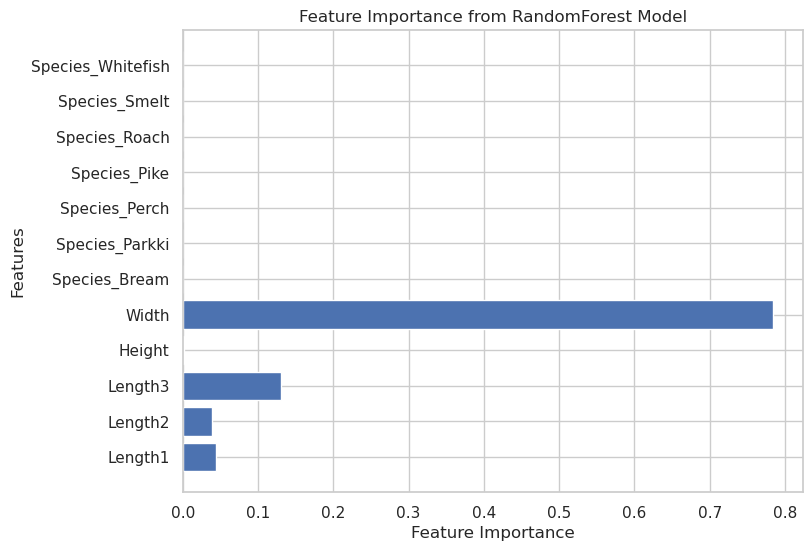

In [159]:
plt.figure(figsize=(8, 6))
plt.barh(X.columns, rf.feature_importances_)
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.title('Feature Importance from RandomForest Model')
plt.show()

The RF just ignores most of the features and only uses width and some lengths for the predictions

Lets try one last model and see if a simple approach works better

## Polynomial Regression

In [160]:
# features and label
X = df.drop('Weight', axis = 1)
y = df['Weight']

# split
X_train, X_test, y_train, y_test = (train_test_split(X, 
                                                     y, 
                                                     test_size=0.2, 
                                                     shuffle=True, 
                                                     random_state=42))

# transform to polynomial features
poly_features = PolynomialFeatures(degree=2)
X_poly = poly_features.fit_transform(X_train)

# fit
polylr = LinearRegression()
polylr.fit(X_poly, y_train)

# coefficients
print("Coefficients:", polylr.coef_)
print("\nIntercept:", polylr.intercept_)

# predict
y_pred = polylr.predict(poly_features.transform(X_test))
print("\nPredictions:", y_pred)

# metrics
print("\nMean Squared Error (MSE):", mean_squared_error(y_test, y_pred))
print("\nR-squared (R^2):", r2_score(y_test, y_pred))
print("\nMean Absolute Error (MAE):", mean_absolute_error(y_test, y_pred))

Coefficients: [-1.28391843e+15 -2.63246335e+02  1.15689057e+03 -6.47109681e+02
  5.89904788e+01 -3.24034614e+01  2.28843376e+02 -3.47515262e+01
  1.41895035e+02 -3.04939491e+02  9.06501813e+01 -2.35165960e+02
  1.13468386e+02 -3.12772958e+03 -4.78199185e+03  6.74206333e+03
  6.72109868e+02  2.79020633e+03 -1.44688046e+03 -8.44773633e+02
  1.31168906e+03 -1.12407090e+02  1.54209447e+02  7.65818853e+02
 -9.09025116e+01  1.12896797e+04 -1.22576513e+04 -4.31408975e+03
 -2.89073097e+02  5.21186782e+03  3.59493703e+03 -3.21588483e+03
 -3.49252600e+03  5.12230481e+01 -1.44015776e+03  4.47431269e+02
  2.09524771e+03  4.85465756e+03 -3.06929940e+03 -5.11231779e+03
 -3.32153726e+03  1.99735666e+03  4.52337960e+03  3.28053569e+02
  1.06449108e+03 -1.26535542e+02 -4.99542187e+02 -2.48003213e+02
  2.89617081e+02  7.28396800e+02  4.07753324e+02 -1.29114980e+03
 -2.51474671e+02  6.81499640e+01  1.07697777e+02  2.65944819e+02
  1.13945108e+03  1.51865834e+01 -3.18133171e+02  6.52767067e+01
 -1.7579690

Slightly worse than the LR,

# Analysis

In [161]:
df_metrics = pd.DataFrame({
    'Model': ['Linear Regression', 'Random Forest', 'Polynomial Regression'],
    'Mean Squared Error (MSE)': [6749.34530388073, 4833.206532268519, 10813.344609374999],
    'R-squared (R^2)': [0.9497220657678428, 0.9639959686134139, 0.9194480939081294],
    'Mean Absolute Error (MAE)': [63.22761533123244, 47.04812469810647, 68.2953125]})

df_metrics

,Model,Mean Squared Error (MSE),R-squared (R^2),Mean Absolute Error (MAE)
0,Linear Regression,6749.345304,0.949722,63.227615
1,Random Forest,4833.206532,0.963996,47.048125
2,Polynomial Regression,10813.344609,0.919448,68.295312


Seems again the RF performed the best and with the tuned rf model, it actually performs quite well on new data.

One problem is that it seems to ignore the species entirely and only use the width to predict.

Lets take a deeper look in the predictions of the models

## Linear Regression

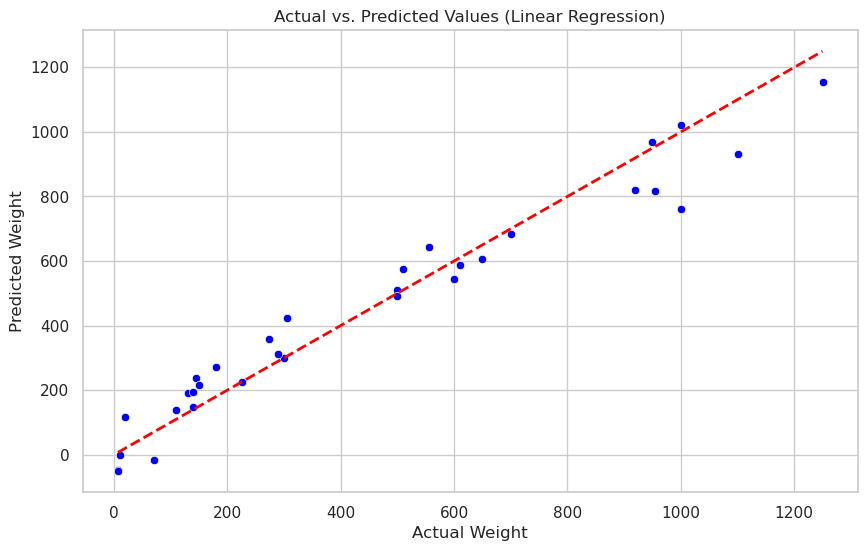

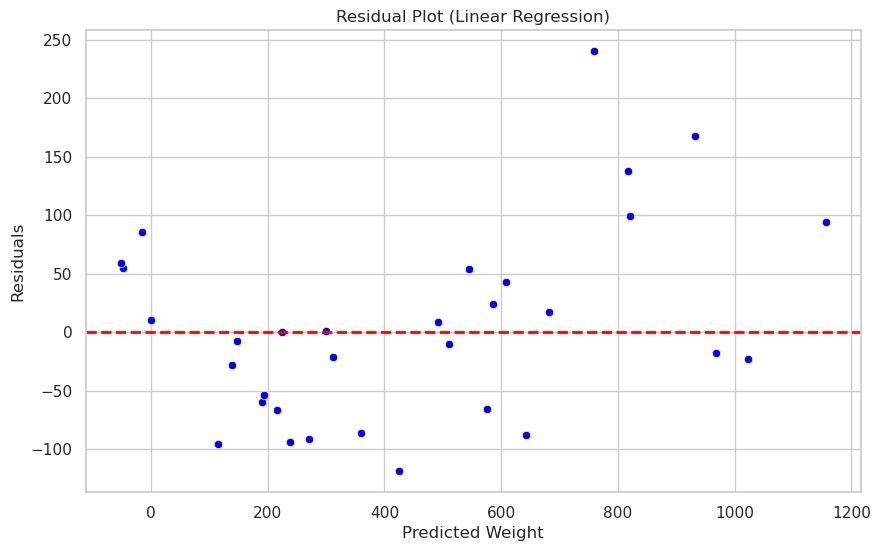

In [162]:
# features and label
X = df.drop('Weight', axis = 1)
y = df['Weight']

# split
X_train, X_test, y_train, y_test = (train_test_split(X, 
                                                     y, 
                                                     test_size=0.2, 
                                                     shuffle=True, 
                                                     random_state=42))

# fit predict
lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)

# seaborn scallerplot
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_test, y=y_pred, color='blue')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], linestyle='--', color='red', linewidth=2)
plt.xlabel('Actual Weight')
plt.ylabel('Predicted Weight')
plt.title('Actual vs. Predicted Values (Linear Regression)')
plt.grid(True)
plt.show()

# residual plot
residuals = y_test - y_pred
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_pred, y=residuals, color='blue')
plt.axhline(y=0, color='red', linestyle='--', linewidth=2)
plt.xlabel('Predicted Weight')
plt.ylabel('Residuals')
plt.title('Residual Plot (Linear Regression)')
plt.grid(True)
plt.show()

Predictions seems to be nicely correlated with actual values

Most residuals are close to 0, meaning low difference between pred and y_true, some outliers, which maybe skew metrics more than at first glance

## Random Forest

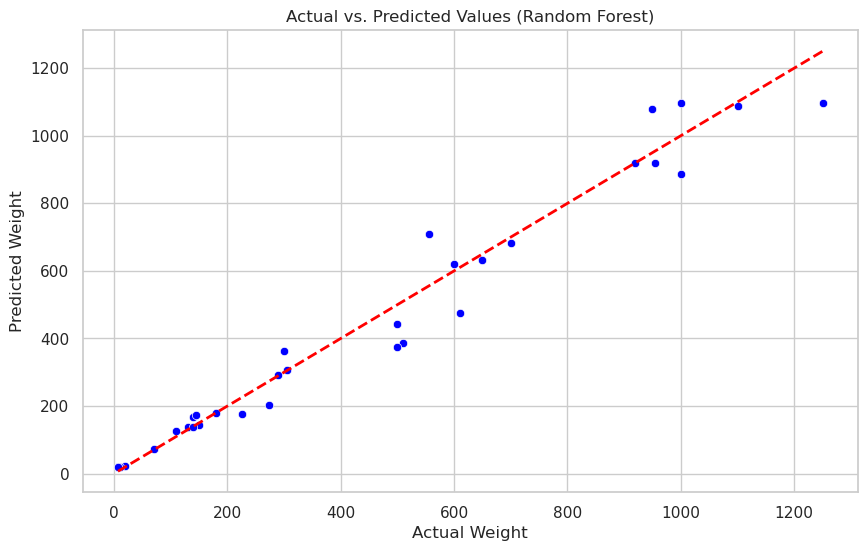

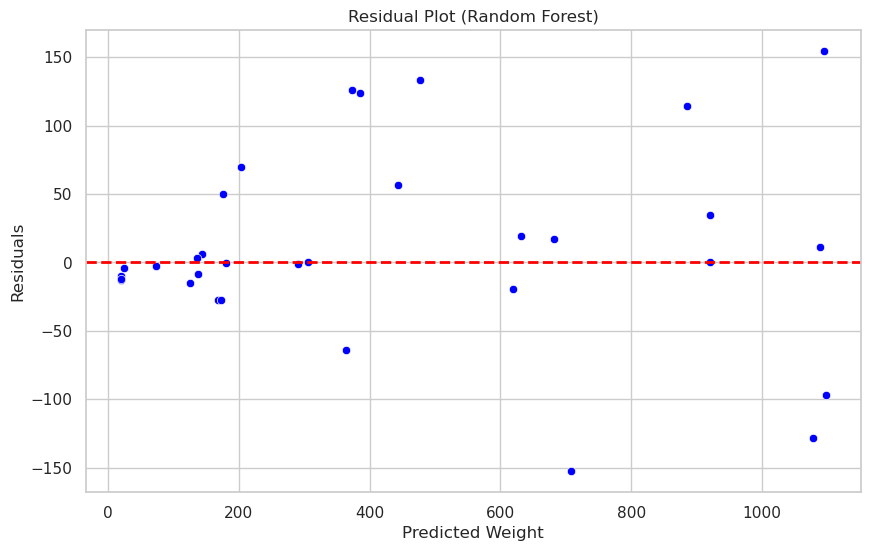

In [163]:
# get the best performing params
best_params = study.best_params

# train new model with the best params
rf = RandomForestRegressor(
    n_estimators=best_params['n_estimators'],
    max_depth=best_params['max_depth'],
    min_samples_split=best_params['min_samples_split'],
    min_samples_leaf=best_params['min_samples_leaf'],
    random_state=random_seed
)

# fit predict
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

# scatter
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_test, y=y_pred, color='blue')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], linestyle='--', color='red', linewidth=2)
plt.xlabel('Actual Weight')
plt.ylabel('Predicted Weight')
plt.title('Actual vs. Predicted Values (Random Forest)')
plt.grid(True)
plt.show()

# res plot
residuals = y_test - y_pred
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_pred, y=residuals, color='blue')
plt.axhline(y=0, color='red', linestyle='--', linewidth=2)
plt.xlabel('Predicted Weight')
plt.ylabel('Residuals')
plt.title('Residual Plot (Random Forest)')
plt.grid(True)
plt.show()

Even better fit than the lr

Important to notice in the residuals, compared to the lr, there are fewer outliers, indicating that the rf deals better the unusual data.

Again, keep in mind, it mostly looks at width and height and ignore the other features

## Polynomial Regression

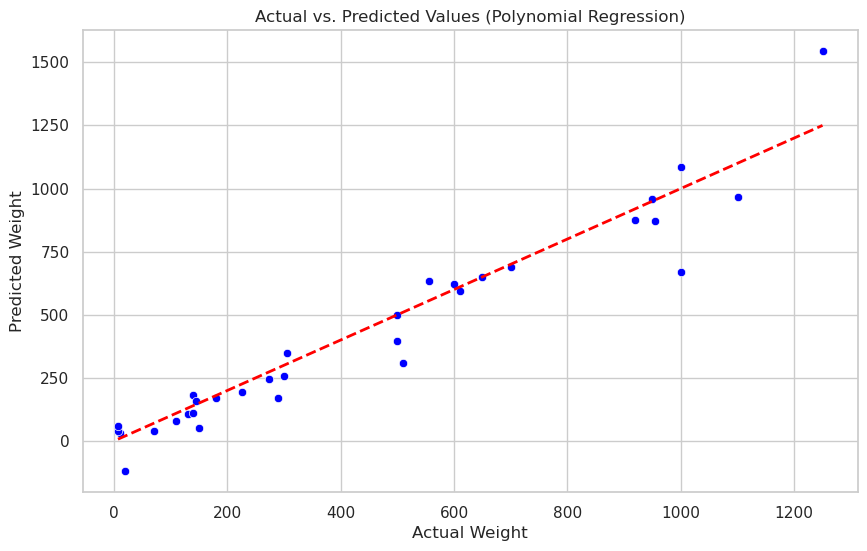

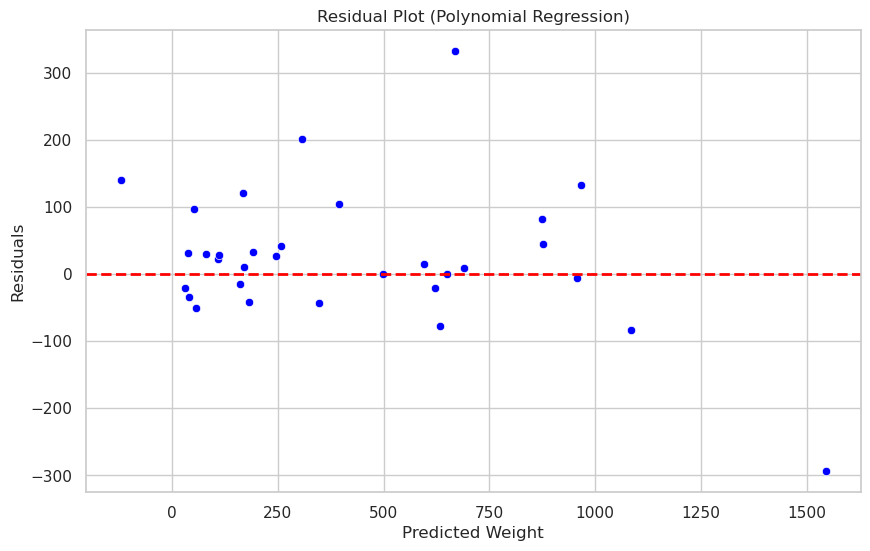

In [164]:
# features and label
X = df.drop('Weight', axis = 1)
y = df['Weight']

# split
X_train, X_test, y_train, y_test = (train_test_split(X, 
                                                     y, 
                                                     test_size=0.2, 
                                                     shuffle=True, 
                                                     random_state=42))

# transform to polynomial features
poly_features = PolynomialFeatures(degree=2)
X_poly = poly_features.fit_transform(X_train)

# fit
polylr = LinearRegression()
polylr.fit(X_poly, y_train)

# predictions
y_pred = polylr.predict(poly_features.transform(X_test))

# scatter
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_test, y=y_pred, color='blue')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], linestyle='--', color='red', linewidth=2)
plt.xlabel('Actual Weight')
plt.ylabel('Predicted Weight')
plt.title('Actual vs. Predicted Values (Polynomial Regression)')
plt.grid(True)
plt.show()

# res plot
residuals = y_test - y_pred
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_pred, y=residuals, color='blue')
plt.axhline(y=0, color='red', linestyle='--', linewidth=2)
plt.xlabel('Predicted Weight')
plt.ylabel('Residuals')
plt.title('Residual Plot (Polynomial Regression)')
plt.grid(True)
plt.show()

Really had high hopes for this one, that it would catch the nonlinear relations that the LR didnt.

Looking at the plots we see why, more outliers that it didnt catch

# Conclusion

RF seems to perform the best, especially with the tuned version that performed better on unseen data

LR performed very nicely for being a relatively simple model, it was the obvious choice with a highly linear pattern in the data and correlations. Still a very respecable performance for a simple model that is easy to explain and understand

PolyLR maybe caught only the non linear patterns and left out the obvious linear patterns.

**Coming to think about it, I should properly have explored a combination of a linear and a polynomial regression....**

Next time!